Train dataset shape:  (370703, 24)
Test dataset shape:  (92676, 23)

Missing values in train data:
 id            0
trans_num     0
trans_date    0
trans_time    0
unix_time     0
category      0
amt           0
cc_num        0
first         0
last          0
gender        0
street        0
city          0
state         0
zip           0
lat           0
long          0
city_pop      0
job           0
dob           0
merchant      0
merch_lat     0
merch_long    0
is_fraud      0
dtype: int64

Missing values in test data:
 id            0
trans_num     0
trans_date    0
trans_time    0
unix_time     0
category      0
amt           0
cc_num        0
first         0
last          0
gender        0
street        0
city          0
state         0
zip           0
lat           0
long          0
city_pop      0
job           0
dob           0
merchant      0
merch_lat     0
merch_long    0
dtype: int64


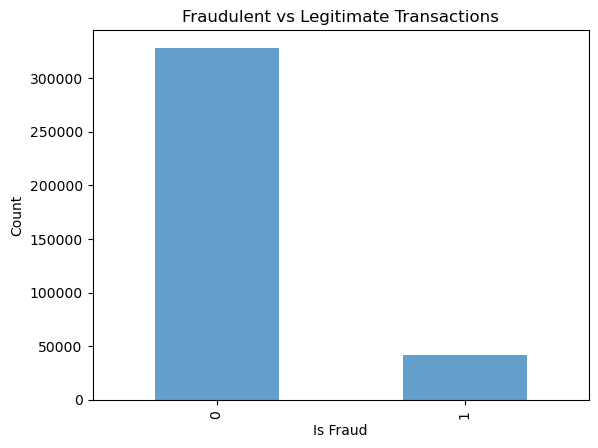

In [5]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix

# Load datasets
tqdm.pandas()
trainingSet = pd.read_csv("train.csv")
testingSet = pd.read_csv("test.csv")

# Check dataset shapes
print("Train dataset shape: ", trainingSet.shape)
print("Test dataset shape: ", testingSet.shape)

# Check for null values
print("\nMissing values in train data:\n", trainingSet.isnull().sum())
print("\nMissing values in test data:\n", testingSet.isnull().sum())

# Visualize target variable distribution
trainingSet['is_fraud'].value_counts().plot(kind='bar', alpha=0.7)
plt.title("Fraudulent vs Legitimate Transactions")
plt.xlabel("Is Fraud")
plt.ylabel("Count")
plt.show()


In [6]:
# Feature engineering function
def process_features(data):
    df = data.copy()
    
    # Convert transaction datetime
    df['transaction_datetime'] = pd.to_datetime(df['trans_date'] + ' ' + df['trans_time'])
    
    # Extract date and time features
    df['hour'] = df['transaction_datetime'].dt.hour
    df['day_of_week'] = df['transaction_datetime'].dt.dayofweek
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    
    # Calculate age
    df['dob'] = pd.to_datetime(df['dob'])
    df['age'] = (df['transaction_datetime'] - df['dob']).dt.days // 365
    
    # Log transformation for 'amt'
    df['log_amt'] = np.log1p(df['amt'])
    
    # High amount flag
    amt_threshold = df['amt'].quantile(0.99)
    df['high_amt_flag'] = (df['amt'] > amt_threshold).astype(int)
    
    # Geographic distance
    df['distance_from_home'] = df.apply(
        lambda row: geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).kilometers, axis=1
    )
    
    # Drop unnecessary columns
    df.drop(['trans_date', 'trans_time', 'dob', 'transaction_datetime'], axis=1, inplace=True)
    
    return df

# Apply feature engineering
trainingSet = process_features(trainingSet)
testingSet = process_features(testingSet)


In [7]:
from sklearn.model_selection import StratifiedKFold

# Split data into features and target
X = trainingSet.drop(['is_fraud'], axis=1)
y = trainingSet['is_fraud']

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Identify categorical and numeric columns
categorical_columns = X.select_dtypes(include=['object']).columns
numeric_columns = X.select_dtypes(include=[np.number]).columns

# Combine datasets for consistent preprocessing
combined_data = pd.concat([X_train, X_val, testingSet], axis=0)

# Fit the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_columns),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_columns),
    ]
)
preprocessor.fit(combined_data)

# Transform datasets
X_train_processed = csr_matrix(preprocessor.fit_transform(X_train))
X_val_processed = csr_matrix(preprocessor.transform(X_val))
test_processed = csr_matrix(preprocessor.transform(testingSet))




In [8]:
from sklearn.model_selection import GridSearchCV

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Define parameter grid for LightGBM
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [-1, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=LGBMClassifier(
        boosting_type='gbdt',
        scale_pos_weight=len(y_train_resampled) / sum(y_train_resampled),  # Handle imbalance
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid,
    scoring='f1',
    cv=3,  # 3-fold cross-validation
    verbose=2
)

# Perform grid search
print("Starting GridSearchCV...")
grid_search.fit(X_train_resampled, y_train_resampled)

# Display the best parameters and corresponding F1 score
print("\nBest Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Use the best estimator for final training
best_lgb_model = grid_search.best_estimator_

# Final training with the best parameters
print("\nTraining the best model on all training data...")
best_lgb_model.fit(X_train_resampled, y_train_resampled)

# Evaluate on validation data
y_pred_val = best_lgb_model.predict(X_val_processed)
f1 = f1_score(y_val, y_pred_val)
print("\nValidation F1 Score with Optimized Model:", f1)

# Predict on test data
y_test_pred = best_lgb_model.predict(test_processed)

# Create submission file
submission = pd.DataFrame({
    'id': testingSet['id'],  # Ensure 'id' column exists in the test data
    'is_fraud': y_test_pred
})

# Save the submission file
submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created successfully.")


Starting GridSearchCV...
Fitting 3 folds for each of 324 candidates, totalling 972 fits
[LightGBM] [Info] Number of positive: 164202, number of negative: 164202
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 4.662923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320814
[LightGBM] [Info] Number of data points in the train set: 328404, number of used features: 17401
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=-1, n_estimators=100, num_leaves=31, subsample=0.8; total time=  16.7s
[LightGBM] [Info] Number of positive: 164202, number of negative: 164202
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 4.704484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26979